# Collect Results from the Training, Pick the Best MolDQN
Get the results from the different runs and mark the MolDQN which was the best

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import json
import os

Things to configure

In [10]:
top_mols_to_save = 8192

## Get all the Results
Get the results of any models

In [11]:
dirs = list(filter(os.path.isdir, glob(os.path.join('rl_tests', '*'))))
print(f'Found {len(dirs)} run directories')

Found 2 run directories


In [12]:
def summarize_run(path: str) -> dict:
    """Summarize the performance of a certain run
    
    Args:
        path (str): Path to the ML run
    Returns:
        (dict) Run summary
    """
    
    # First, load in the configuratoin
    with open(os.path.join(path, 'config.json')) as fp:
        output = json.load(fp)
    output['path'] = path
        
    # Load in the name of the system and some other performance details
    perf_path = os.path.join(path, 'performance.json')
    if os.path.isfile(perf_path):
        with open(perf_path) as fp:
            perf = json.load(fp)
            for k in ['hostname', 'runtime']:
                output[k] = perf[k]
        output['complete'] = True
    else:
        output['complete'] = False
            
    # Assess the run data
    try:
        mols = pd.read_csv(os.path.join(path, 'molecules.csv'))
    except:
        return output
    if not output['maximize']:
        mols['reward'] = -1 * mols['reward']
    output['episodes_completed'] = mols['episode'].max() + 1
    output['rewards_computed'] = len(mols)
    output['unique_molecules'] = len(set(mols['smiles']))
    output['unique_fraction'] = output['unique_molecules'] / len(mols)
    output['best_found'] = -1 * mols['u0_atom'].max()
    output['below_4ha'] = len(set(mols.query('u0_atom >= 4')['smiles']))
        
    return output

In [13]:
results = pd.DataFrame(summarize_run(d) for d in dirs).sort_values('below_4ha', ascending=False)
results.head()#[['path', 'rewards_computed', 'unique_fraction', 'best_found', 'below_8ha']]

,epsilon,epsilon_min,epsilon_decay,max_steps,episodes,q_update_freq,reward,hidden_layers,gamma,fingerprint_size,...,path,hostname,runtime,complete,episodes_completed,rewards_computed,unique_molecules,unique_fraction,best_found,below_4ha
0,1.0,0.25,0.9995,40,20000,10,u0_atom,"[1024, 512, 128, 32]",0.9,2048,...,rl_tests/u0_atom_2020-11-17T15.08.47.783708,venti,126513.464750,True,20000,788764,384472,0.487436,-4.671474,15045
1,1.0,0.25,0.9995,40,20000,10,u0_atom,"[1024, 512, 128, 32]",0.9,2048,...,rl_tests/u0_atom_2020-11-09T09.03.19.156032,venti,120538.532525,True,20000,795773,340382,0.427738,-3.101141,0


In [14]:
best_run = results.query('complete').iloc[0]

In [15]:
best_run

epsilon                                                         1
epsilon_min                                                  0.25
epsilon_decay                                              0.9995
max_steps                                                      40
episodes                                                    20000
q_update_freq                                                  10
reward                                                    u0_atom
hidden_layers                                [1024, 512, 128, 32]
gamma                                                         0.9
fingerprint_size                                             2048
batch_size                                                     32
no_backtrack                                                False
initial_molecule                                             None
max_size                                                       13
maximize                                                    False
path      

## Link the best agent to the local directory
So that we can easily access it later

In [16]:
if os.path.islink('agent.pkl'):
    os.unlink('agent.pkl')
os.symlink(os.path.join(best_run['path'], 'agent.pkl'), 'agent.pkl')

## Save a list of "top molecules"
So that we can seed the molecular design engine

In [17]:
mols = pd.read_csv(os.path.join(best_run.path, 'molecules.csv'))

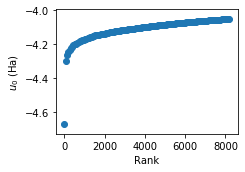

In [18]:
fig, ax, = plt.subplots(figsize=(3.5, 2.5))

# Get the top points by value
x = np.linspace(0, top_mols_to_save, 128, dtype=np.int)
u_0 = np.sort(mols.drop_duplicates('smiles')['u0_atom'])
v = [-u_0[-i-1] for i in x]

ax.scatter(x, v)
ax.set_xlabel('Rank')
ax.set_ylabel('$u_0$ (Ha)')
fig.tight_layout()

In [19]:
with open('best_mols.json', 'w') as fp:
    best_list = list(set(mols.sort_values('u0_atom').drop_duplicates('smiles').tail(top_mols_to_save)['smiles']))
    json.dump(best_list, fp)